## Valute Iteration and Policy Iteration (OpenAI Gym - Taxi-v3)

In [49]:
import numpy as np
from timeit import default_timer as timer

def value_iteration(env, theta=0.0001, gamma=1.0):
    """
    Value Iteration Algorithm.
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment.
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than delta for all states.
        gamma: Gamma discount factor.
    Returns:
        A tuple (policy, V, iterations) of the optimal policy, the optimal value function, and iterations.
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A

    V = np.zeros(env.nS)
    delta_list = []
    time_list = []
    cum_time_list = []
    total_value_list = []
    iterations = 0
    while True:
        start_time = timer()
        iterations += 1
        delta = 0
        for state in range(env.nS):
            A = one_step_lookahead(state, V)  
            best_act_value = np.max(A)
            delta = max(delta, np.abs(best_act_value - V[state]))
            V[state] = best_act_value  # update value to best action value
            
        end_time = timer()
        run_time = end_time - start_time
        delta_list.append(delta)
        time_list.append(run_time)
        cum_time_list.append(sum(time_list))
        total_value_list.append(np.sum(V))
        
        if delta < theta:  # if delta improvement is less than threshold
            break
            
    policy = np.zeros([env.nS, env.nA])
    for state in range(env.nS): 
        A = one_step_lookahead(state, V)
        best_action = np.argmax(A)
        policy[state][best_action] = 1.0
        
    return policy, V, iterations, delta_list, time_list, cum_time_list, total_value_list

def policy_evaluation(policy, env, theta=0.0001, gamma=1.0, max_steps=3000):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment.
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        gamma: Gamma discount factor.
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    steps = 0
    while steps < max_steps:
        delta = 0
        steps += 1
        for state in range(env.nS):
            val = 0  # initiate value as 0
            for action, act_prob in enumerate(policy[state]):  # for all actions/action probabilities
                for prob, next_state, reward, done in env.P[state][action]:
                    val += act_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(val - V[state]))
            V[state] = val
        if delta < theta:  # if delta improvement is less than threshold
            break
    return np.array(V)


def policy_iteration(env, policy_eval_function=policy_evaluation, gamma=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    Args:
        env: The OpenAI envrionment.
        policy_eval_function: Policy Evaluation function that takes 3 arguments:
            policy, env, gamma.
        discount_factor: gamma discount factor.
    Returns:
        A tuple (policy, V).
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A
    
    policy = np.ones([env.nS, env.nA]) / env.nA # Start with a random policy
    time_list = []
    cum_time_list = []
    total_value_list = []
    iterations = 0
    while True:
        start_time = timer()
        iterations += 1
        curr_pol_value = policy_eval_function(policy, env, gamma)  # eval current policy
        policy_stable = True  # Check if policy did improve
        for state in range(env.nS): 
            chosen_act = np.argmax(policy[state])  # best action base on current policy
            act_values = one_step_lookahead(state, curr_pol_value)
            best_act = np.argmax(act_values)  # find best action
            best_act_value = np.max(act_values)
            if chosen_act != best_act:
                policy_stable = False  # Greedily find best action
            policy[state] = np.eye(env.nA)[best_act]  # update
            
        end_time = timer()
        run_time = end_time - start_time
        time_list.append(run_time)
        cum_time_list.append(sum(time_list))
        total_value_list.append(np.sum(curr_pol_value))
        
        if policy_stable:
            return policy, curr_pol_value, iterations, time_list, cum_time_list, total_value_list

    return policy, np.zeros(env.nS), iterations, time_list, cum_time_list, total_value_list

In [50]:
import gym
import seaborn as sns
import matplotlib.pyplot as plt

env_name  = 'Taxi-v3'
env = gym.make(env_name)
gammas = [0.99, 0.95, 0.90]
gammas2 = [0.99, 0.8, 0.5]
vi_results = {}
pi_results = {}
for gamma in gammas:
    start = timer()
    policy, V, iterations, delta, time, cum_time, total_value = value_iteration(env, gamma=gamma)
    end = timer()
    print("Value Iteration: {}s in {} iters with gamma={}".format(end - start, iterations, gamma))
    vi_results[gamma] = (policy, V, iterations, delta, time, cum_time, total_value)
    env.reset()

for gamma in gammas2:
    start = timer()
    policy2, V2, iterations2, time2, cum_time2, total_value2 = policy_iteration(env, policy_evaluation, gamma=gamma)
    end = timer()
    print("Policy Iteration: {}s in {} iters with gamma={}".format(end - start, iterations2, gamma))
    pi_results[gamma] = (policy2, V2, iterations2, time2, cum_time2, total_value2)
    env.reset()

Value Iteration: 6.598343885998474s in 610 iters with gamma=0.99
Value Iteration: 1.432091890979791s in 124 iters with gamma=0.95
Value Iteration: 0.7339085020066705s in 63 iters with gamma=0.9
Policy Iteration: 331.80363665000186s in 15 iters with gamma=0.99
Policy Iteration: 303.5722986269975s in 15 iters with gamma=0.8
Policy Iteration: 304.90315398800885s in 15 iters with gamma=0.5


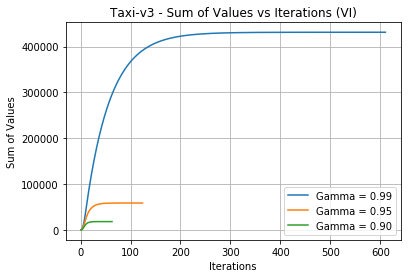

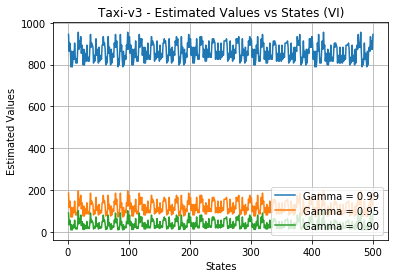

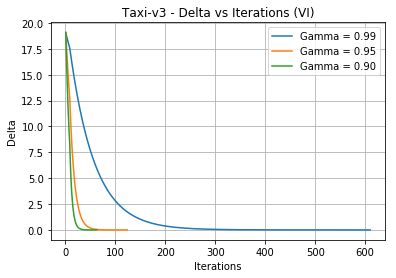

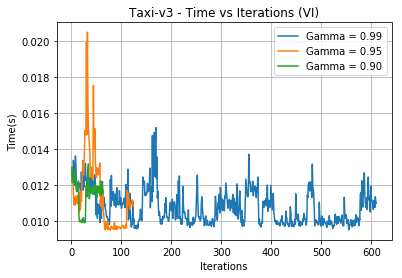

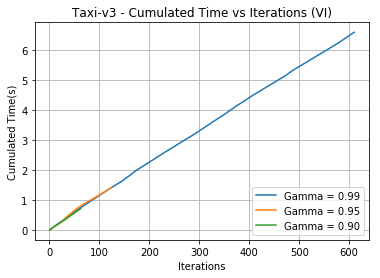

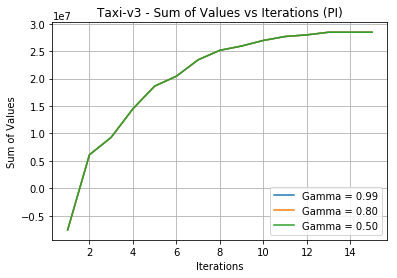

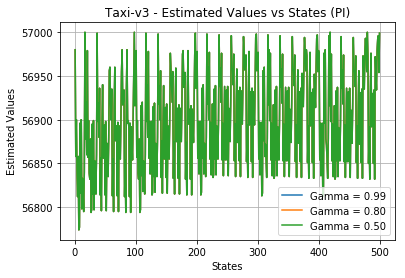

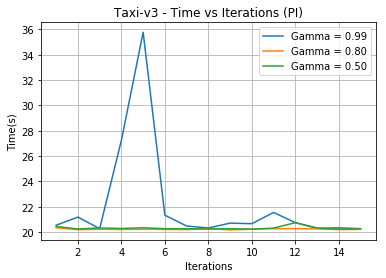

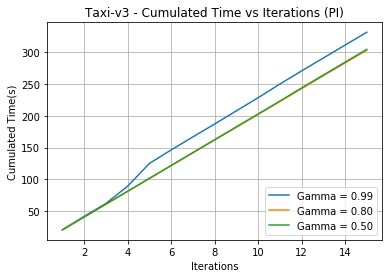

<Figure size 432x288 with 0 Axes>

In [53]:
# Switch plot backend
plt.switch_backend('Agg')
%matplotlib inline

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[6],label=label)
plt.title("Taxi-v3 - Sum of Values vs Iterations (VI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Sum of Values')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, 501),results[1],label=label)
plt.title("Taxi-v3 - Estimated Values vs States (VI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('States')
plt.ylabel('Estimated Values')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[3],label=label)
plt.title("Taxi-v3 - Delta vs Iterations (VI)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Delta')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[4],label=label)
plt.title("Taxi-v3 - Time vs Iterations (VI)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[5],label=label)
plt.title("Taxi-v3 - Cumulated Time vs Iterations (VI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Cumulated Time(s)')
plt.show()
plt.clf() 
    
for gamma, results in pi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[5],label=label)
plt.title("Taxi-v3 - Sum of Values vs Iterations (PI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Sum of Values')
plt.show()
plt.clf() 

for gamma, results in pi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, 501),results[1],label=label)
plt.title("Taxi-v3 - Estimated Values vs States (PI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('States')
plt.ylabel('Estimated Values')
plt.show()
plt.clf() 

for gamma, results in pi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[3],label=label)
plt.title("Taxi-v3 - Time vs Iterations (PI)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

for gamma, results in pi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[4],label=label)
plt.title("Taxi-v3 - Cumulated Time vs Iterations (PI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Cumulated Time(s)')
plt.show()
plt.clf() 

In [84]:
policy = vi_results[0.99][0]
policy2 = pi_results[0.99][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = pi_results[0.8][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = pi_results[0.5][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = vi_results[0.95][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = vi_results[0.90][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

Same Policy
Same Policy
Same Policy
Same Policy
Same Policy


## Q-Learning (OpenAI Gym - Taxi-v3)

In [68]:
import numpy as np
from collections import defaultdict

class Agent:

    def __init__(self, nA=6, epsilon=0.005, alpha=0.1, gamma=0.9):
        """ Initialize agent.
        Params
        ======
        - nA: number of actions available to the agent
        """
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def epsilon_greedy_prob(self, state):
        if state in self.Q.keys():
            probs = [self.epsilon / self.nA for i in range(self.nA)]
            argmax = np.argmax(self.Q[state])
            probs[argmax] += (1 - self.epsilon)
        else:
            probs = [1 / self.nA for i in range(self.nA)]
        return probs

    def select_action(self, state, i_episode):
        """ Given the state, select an action.
        Params
        ======
        - state: the current state of the environment
        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        policy_s = self.epsilon_greedy_prob(state)
        return np.random.choice(np.arange(self.nA), p=policy_s)

    def update_Q(self, Qsa, Qsa_next, reward):
        """ updates the action-value function estimate using the most recent step"""
        Qsa = (1 - self.alpha) * Qsa + self.alpha * (reward + self.gamma * Qsa_next)
        return Qsa

    def step(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        self.Q[state][action] = self.update_Q(self.Q[state][action], np.max(self.Q[next_state]), reward)
        
def Q_learning(alpha, gamma, epsilon, num_episodes=100000):
    env = gym.make('Taxi-v3')
    agent = Agent(epsilon=epsilon, alpha=alpha, gamma=gamma)
    
    reward_list = []
    time_list = []
    cum_time_list = []
    steps_list = []
    
    for i_episode in range(1, num_episodes+1):
        # begin the episode
        state = env.reset()
        start_time = timer()
        total_rewards = 0
        steps = 0
        while True:
            steps += 1
            # agent selects an action
            action = agent.select_action(state, i_episode)
            # agent performs the selected action
            next_state, reward, done, _ = env.step(action)
            total_rewards += reward
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                break
        end_time = timer()
        time_list.append(end_time - start_time)
        cum_time_list.append(sum(time_list))
        reward_list.append(total_rewards)
        steps_list.append(steps)
        
    policy = np.ones([env.nS, env.nA]) / env.nA
    for state in range(env.nS):  # for each states
        best_act = np.argmax(agent.Q[state])  # find best action
        policy[state] = np.eye(env.nA)[best_act]  # update
        
    return policy, agent.Q, reward_list, time_list, cum_time_list, steps_list

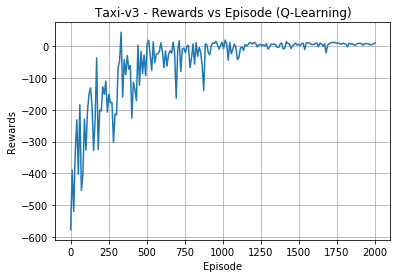

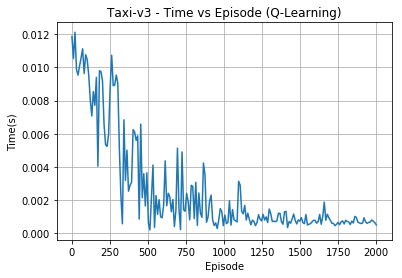

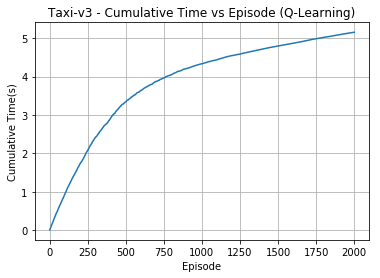

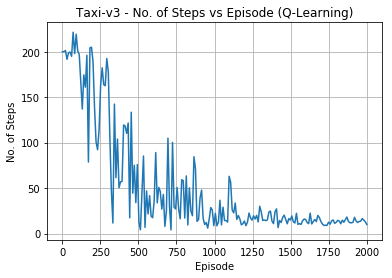

<Figure size 432x288 with 0 Axes>

In [93]:
q_policy, q_table, reward, time, cum_time, steps = Q_learning(alpha=0.1, gamma=0.9, epsilon=0.005, num_episodes=2000)

from scipy.interpolate import make_interp_spline, BSpline
episode_new = np.linspace(1, 2000, 200) 

spl = make_interp_spline(range(1, 2001), reward, k=3)  # type: BSpline
power_smooth = spl(episode_new)
plt.plot(episode_new, power_smooth)
plt.title("Taxi-v3 - Rewards vs Episode (Q-Learning)")
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()
plt.clf() 

spl = make_interp_spline(range(1, 2001), time, k=3)  # type: BSpline
power_smooth = spl(episode_new)
plt.plot(episode_new,power_smooth)
plt.title("Taxi-v3 - Time vs Episode (Q-Learning)")
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

plt.plot(range(1, 2001),cum_time)
plt.title("Taxi-v3 - Cumulative Time vs Episode (Q-Learning)")
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Cumulative Time(s)')
plt.show()
plt.clf() 

spl = make_interp_spline(range(1, 2001), steps, k=3)  # type: BSpline
power_smooth = spl(episode_new)
plt.plot(episode_new,power_smooth)
plt.title("Taxi-v3 - No. of Steps vs Episode (Q-Learning)")
plt.grid()
plt.xlabel('Episode')
plt.ylabel('No. of Steps')
plt.show()
plt.clf() 

In [94]:
alphas = [0.5, 0.1, 0.01]
gammas = [0.9, 0.8, 0.7]
epsilons = [0.005, 0.01, 0.05]
alphas_results = {}
gammas_results = {}
epsilon_results = {}

for alpha in alphas:
    q_policy, q_table, reward, time, cum_time, steps = Q_learning(alpha=alpha, gamma=0.9, epsilon=0.005, num_episodes=2000)
    alphas_results[alpha] = (q_policy, q_table, reward, time, cum_time, steps)

for gamma in gammas:
    q_policy, q_table, reward, time, cum_time, steps = Q_learning(alpha=0.1, gamma=gamma, epsilon=0.005, num_episodes=2000)
    gammas_results[gamma] = (q_policy, q_table, reward, time, cum_time, steps)
    
for epsilon in epsilons:
    q_policy, q_table, reward, time, cum_time, steps = Q_learning(alpha=0.1, gamma=0.9, epsilon=epsilon, num_episodes=2000)
    epsilon_results[epsilon] = (q_policy, q_table, reward, time, cum_time, steps)

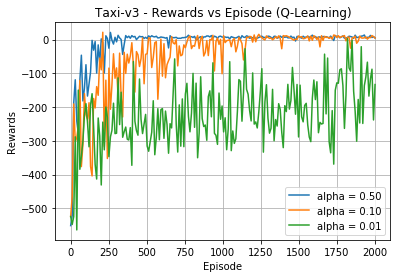

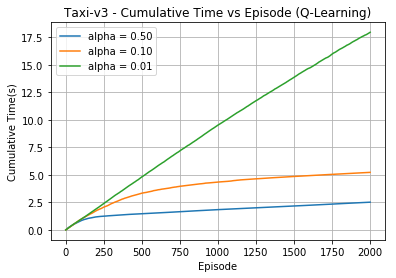

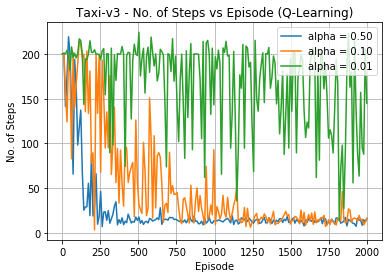

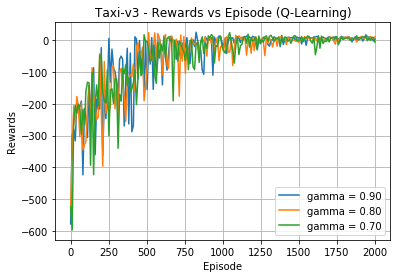

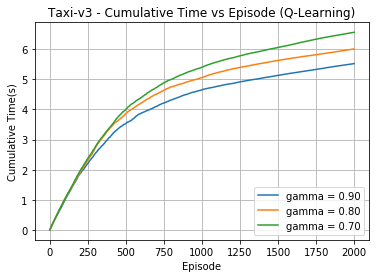

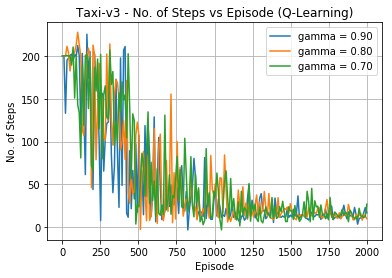

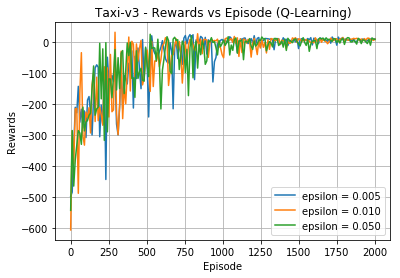

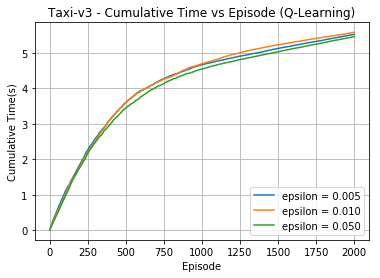

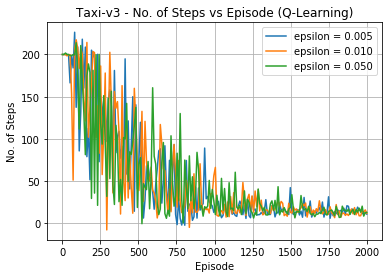

<Figure size 432x288 with 0 Axes>

In [95]:
episode_new = np.linspace(1, 2000, 200) 

for alpha, results in alphas_results.items():
    label = "alpha = %.2f" %alpha
    spl = make_interp_spline(range(1, 2001), results[2], k=3)  # type: BSpline
    power_smooth = spl(episode_new)
    plt.plot(episode_new, power_smooth,label=label)
plt.title("Taxi-v3 - Rewards vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()
plt.clf() 

for alpha, results in alphas_results.items():
    label = "alpha = %.2f" %alpha
    plt.plot(range(1, 2001),results[4],label=label)
plt.title("Taxi-v3 - Cumulative Time vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='upper left')
plt.xlabel('Episode')
plt.ylabel('Cumulative Time(s)')
plt.show()
plt.clf() 

for alpha, results in alphas_results.items():
    label = "alpha = %.2f" %alpha
    spl = make_interp_spline(range(1, 2001), results[5], k=3)  # type: BSpline
    power_smooth = spl(episode_new)
    plt.plot(episode_new, power_smooth,label=label)
plt.title("Taxi-v3 - No. of Steps vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Episode')
plt.ylabel('No. of Steps')
plt.show()
plt.clf() 

for gamma, results in gammas_results.items():
    label = "gamma = %.2f" %gamma
    spl = make_interp_spline(range(1, 2001), results[2], k=3)  # type: BSpline
    power_smooth = spl(episode_new)
    plt.plot(episode_new, power_smooth,label=label)
plt.title("Taxi-v3 - Rewards vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()
plt.clf() 

for gamma, results in gammas_results.items():
    label = "gamma = %.2f" %gamma
    plt.plot(range(1, 2001),results[4],label=label)
plt.title("Taxi-v3 - Cumulative Time vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Cumulative Time(s)')
plt.show()
plt.clf() 

for gamma, results in gammas_results.items():
    label = "gamma = %.2f" %gamma
    spl = make_interp_spline(range(1, 2001), results[5], k=3)  # type: BSpline
    power_smooth = spl(episode_new)
    plt.plot(episode_new, power_smooth,label=label)
plt.title("Taxi-v3 - No. of Steps vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Episode')
plt.ylabel('No. of Steps')
plt.show()
plt.clf() 

for epsilon, results in epsilon_results.items():
    label = "epsilon = %.3f" %epsilon
    spl = make_interp_spline(range(1, 2001), results[2], k=3)  # type: BSpline
    power_smooth = spl(episode_new)
    plt.plot(episode_new, power_smooth,label=label)
plt.title("Taxi-v3 - Rewards vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()
plt.clf() 

for epsilon, results in epsilon_results.items():
    label = "epsilon = %.3f" %epsilon
    plt.plot(range(1, 2001),results[4],label=label)
plt.title("Taxi-v3 - Cumulative Time vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Cumulative Time(s)')
plt.show()
plt.clf() 

for epsilon, results in epsilon_results.items():
    label = "epsilon = %.3f" %epsilon
    spl = make_interp_spline(range(1, 2001), results[5], k=3)  # type: BSpline
    power_smooth = spl(episode_new)
    plt.plot(episode_new, power_smooth,label=label)
plt.title("Taxi-v3 - No. of Steps vs Episode (Q-Learning)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Episode')
plt.ylabel('No. of Steps')
plt.show()
plt.clf() 